In [1]:
import torch
import os, sys
import numpy as np
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
os.environ['CUDA_VISIBLE_DEVICES']='2'

tensor(0.0002)


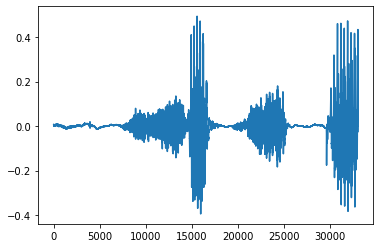

In [4]:
from util.util import compute_matrics,kbdwin
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
audio_path = '/root/VCTK-Corpus/wav48/p227/p227_003.wav'
audio, fs = torchaudio.load(audio_path)
K = 50000
audio_seg = audio[...,K:33024+K].squeeze()
print(audio_seg.mean())
plt.plot(audio_seg)
plt.show()

torch.Size([512, 128])
cuda:0


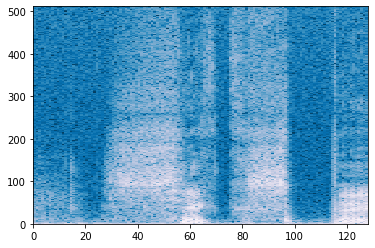

In [27]:
from models.mdct import MDCT2, IMDCT2
mdct2 = MDCT2(n_fft=512, hop_length=256, win_length=512, window=kbdwin, center=False)
spectro_2 = mdct2(audio_seg.cuda().squeeze(0)).permute(1,0)
spectro2 = aF.amplitude_to_DB((spectro_2.abs() + 1e-7),20,1e-7,1).squeeze(0)
print(spectro2.size())
print(spectro2.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro2.cpu().numpy(), cmap='PuBu_r')
plt.show()

torch.Size([33024])
tensor(-7.7201e-05, device='cuda:0')


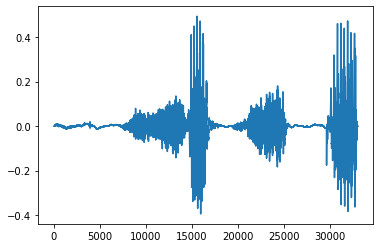

In [28]:
imdct2 = IMDCT2(n_fft=512, hop_length=256, win_length=512, window=kbdwin, center=False)
recover2 = imdct2(spectro_2.permute(1,0).unsqueeze(0).contiguous()).squeeze()
print(recover2.size())
print(recover2.mean())
plt.plot(recover2.cpu().numpy())
plt.show()

In [ ]:
lr_audio = aF.resample(audio_seg,fs,fs/4)
lr_audio = aF.resample(lr_audio,fs/4,fs)
mse,snr_sr,snr_lr,_,_,_,lsd = compute_matrics(audio_seg.cpu(),lr_audio.cpu(),recover2.cpu())

In [8]:
print(snr_lr)
print(snr_sr)
print(mse)
print(lsd)

37.73739576339722
128.8947582244873
2.4056786022876725e-14
0.00023996879463084042


In [47]:
up_ratio = 128
pha = torch.sign(spectro_2)
size = spectro_2.size(-2)
psudo_pha = 2*torch.randint(low=0,high=2,size=spectro_2.size()).cuda()-1
pha = torch.cat((pha[...,:int(size*(1/up_ratio)),:],psudo_pha[...,int(size*(1/up_ratio)):,:]),dim=-2)

torch.Size([33024])
tensor(-6.8419e-05, device='cuda:0')


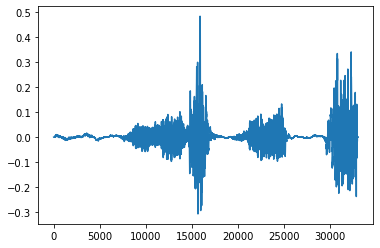

In [48]:
distort = torch.abs(spectro_2)*pha
distort_recover2 = imdct2(distort.permute(1,0).unsqueeze(0).contiguous()).squeeze()
print(distort_recover2.size())
print(distort_recover2.mean())
plt.plot(distort_recover2.cpu().numpy())
plt.show()

In [17]:
lr_audio = torch.rand(32,33024)
hr_audio = torch.rand(32,33024)
sr_audio = hr_audio + 1e10*torch.rand(32,33024)

In [41]:
lr_audio = aF.resample(audio_seg,fs,fs/4)
lr_audio = aF.resample(lr_audio,fs/4,fs)
hr_audio = audio_seg.cpu()
sr_audio = hr_audio + 1e-4*torch.rand(hr_audio.size())
lr_audio = lr_audio.cpu()
# Normalize sr_audio and hr_audio
sr_audio = (sr_audio-sr_audio.min())/(sr_audio.max()-sr_audio.min())
hr_audio = (hr_audio-hr_audio.min())/(hr_audio.max()-hr_audio.min())
lr_audio = (lr_audio-lr_audio.min())/(lr_audio.max()-lr_audio.min())
transform = torchaudio.transforms.Spectrogram(power=2)
hr_stft = transform(hr_audio)
sr_stft = transform(sr_audio)
hr_stft_log = torch.log10(hr_stft+1e-6)
sr_stft_log = torch.log10(sr_stft+1e-6)
lsd = torch.sqrt(torch.mean((hr_stft_log-sr_stft_log)**2,dim=-1)).mean().item()
mse = ((sr_audio-hr_audio)**2).mean().item()
snr_sr = 10*torch.log10(torch.mean(hr_audio**2)/torch.mean((sr_audio-hr_audio)**2)).item()
snr_lr = 10*torch.log10(torch.mean(hr_audio**2)/torch.mean((lr_audio-hr_audio)**2)).item()
#print(snr_lr)
#print(snr_sr)
#print(mse)
print(lsd)

0.05885951220989227


In [40]:
0.18518875539302826*np.sqrt(10)

0.5856182640937598

In [54]:
from torchaudio.functional import DB_to_amplitude, amplitude_to_DB
a = torch.tensor([[1,2,3],[4,5,6]])
b = amplitude_to_DB(a,20,1e-7,1)
c = DB_to_amplitude(b,10,0.5)
print(b,c)

tensor([[-20.0000, -13.9794, -10.4576],
        [ -7.9588,  -6.0206,  -4.4370]]) tensor([[1.0000, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]])
